In [1]:
"""
Python script to scrape Friktion User Data from Bitquery GraphQL API.

"""

import json
import requests
import requests
import traceback
import time

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from os.path import exists


class MyPortfolio:
    """
    Python ETL script for Friktion user portfolio data. Currently supported Instruction Names:
        - Deposit
        - CancelPendingDeposit
        - Withdrawal
        - CancelPendingWithdrawal
        - ClaimPendingWithdrawal
    """

    def __init__(
        self,
        date_start,
        date_end,
        ix_fname="./friktion_ix.csv",
        deposit_fname="./friktion_deposit.csv",
        deposit_cxl_fname="./friktion_deposit_cxl.csv",
        withdraw_fname="./friktion_withdraw.csv",
        withdraw_cxl_fname="./friktion_withdraw_cancel.csv",
        withdraw_claim_fname="./friktion_claim_withdrawal.csv",
        endround_fname="./friktion_end_round2.csv",
        batch_size_days=2,
        batch_size_xfers=80,
        skip_ix_scrape=False
    ):
        """
        :ix_fname:              output csv for instructions
        :deposit_fname:         output csv for deposits
        :deposit_cxl_fname:     output csv for deposit cancels
        :withdraw_fname:        output csv for withdrawals
        :withdraw_cxl_fname:    output csv for withdrawal cancels
        :withdraw_claim_fname:  output csv for claiming pending withdrawal
        :batch_size_days:       batch size in days for query to keep query < 10k symbols. Use bigger steps for larger data.
        :batch_size_transfers:  batch size transactions for query to keep query < 8kb

        """
        self.volt_program = "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"
        self.date_start = date_start
        self.date_end = date_end
        self.ix_fname = ix_fname
        self.deposit_fname = deposit_fname
        self.deposit_cxl_fname = deposit_cxl_fname
        self.withdraw_fname = withdraw_fname
        self.withdraw_cxl_fname = withdraw_cxl_fname
        self.withdraw_claim_fname = withdraw_claim_fname
        self.end_round_fname = endround_fname
        self.batch_size_days = batch_size_days
        self.batch_size_xfers = batch_size_xfers
        self.skip_ix_scrape = skip_ix_scrape
        
        self.df_ix = pd.read_csv(ix_fname) if skip_ix_scrape else [] 
        self.friktion_metadata = self.get_friktion_snapshot()

    ########################################################################################################
    ####################################          Queries             ######################################
    ########################################################################################################

    @property
    def ix_query(self):
        return """
            query MyQuery {
              solana {
                instructions(
                  time: {between: ["%s", "%s"]}
                  success: {is: true}
                  programId: {is: "VoLT1mJz1sbnxwq5Fv2SXjdVDgPXrb9tJyC8WpMDkSp"}
                  options: {limit: 8700}
                ) {
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  transaction {
                    signature
                    feePayer
                  }
                  data {
                    base58
                  }
                }
              }
            }
        """

    @property
    def xfer_query(self):
        return """
            query MyQuery {
              solana(network: solana) {
                transfers(
                  signature: {in: [%s]}
                  options: {limit: 2000}
                ) {
                  instruction {
                    action {
                      name
                    }
                    callPath
                  }
                  amount(success: {is: true})
                  transaction {
                    signer
                    signature
                  }
                  block {
                    timestamp {
                      iso8601
                    }
                  }
                  currency {
                    name
                    address
                  }
                  sender {
                    address
                    mintAccount
                  }
                  receiver {
                    address
                  }
                }
              }
            }
        """

    ########################################################################################################
    ################################          Helper Functions             #################################
    ########################################################################################################

    # TODO: Add retry logic to this in case of hangups.
    @staticmethod
    def run_query(query, retries=10):
        """
        Query graphQL API.

        If timeerror
        """
        headers = {"X-API-KEY": "BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4"}

        retries_counter = 0
        try:
            request = requests.post(
                "https://graphql.bitquery.io/", json={"query": query}, headers=headers
            )
            result = request.json()
            # print(dir(request.content))
            # Make sure that there is no error message
            # assert not request.content.errors
            assert "errors" not in result
        except:
            while (
                (request.status_code != 200
                or "errors" in result)
                and retries_counter < 10
            ):
                print(datetime.now(), f"Retry number {retries_counter}")
                if "errors" in result:
                    print(result["errors"])
                print(datetime.now(), f"Query failed for reason: {request.reason}. sleeping for {150*retries_counter} seconds and retrying...")
                time.sleep(150*retries_counter)
                request = requests.post(
                    "https://graphql.bitquery.io/",
                    json={"query": query},
                    headers=headers,
                )
                retries_counter += 1
            if retries_counter >= retries:
                raise Exception(
                    "Query failed after {} retries and return code is {}.{}".format(
                        retries_counter, request.status_code, query
                    )
                )
        return request.json()


    @staticmethod
    def batch_iterable(iterable, n=1):
        """
        Takes in an iterable and returns an iterable of iterables with len==x
        """
        idxs = []
        l = len(iterable)
        for idx in range(0, l, n):
            idxs.append(iterable[idx : min(idx + n, l)])
        return idxs

    def format_txs_for_query(self, tx_signatures):
        """
        Batches a list of transactions into a list of string formatted transactions for querying.
        Each of these strings contain (n=self.batch_size_xfers) unique transaction IDs.
        """
        batched_signatures = self.batch_iterable(tx_signatures, self.batch_size_xfers)

        def format_txs(x):
            return str(x)[1:-1].replace("'", '"').replace("\n", "")

        tx_strs = list(map(format_txs, batched_signatures))

        return tx_strs

    def get_existing_df(self, fname):
        """
        Create output file if doesn't exist and returns a DataFrame
        """
        if fname and exists(fname):
            return pd.read_csv(fname)
        else:
            return pd.DataFrame()

    @staticmethod
    def instruction_match(instructionData):
        """
        Match 8-bit instruction identifier with the corresonding instructionType
        """
        if not instructionData or len(instructionData) < 8:
            return False

        instructionDescriptor = instructionData[:8]

        if instructionDescriptor == "A4eeE44X":
            return "EndRound"

    def get_friktion_snapshot(self):
        """
        Load Friktion Metadata for Volt/Symbol Mapping to join to normal data

        """
        try:
            return pd.DataFrame(
                dict(
                    json.loads(
                        requests.get(
                            "https://friktion-labs.github.io/mainnet-tvl-snapshots/friktionSnapshot.json"
                        ).content
                    )
                )["allMainnetVolts"]
            )[
                [
                    "globalId",
                    "vaultAuthority",
                    "shareTokenMint",
                    "depositTokenSymbol",
                    "depositTokenCoingeckoId",
                ]
            ]
        except Exception as e:
            print(datetime.now(), "Snapshot Data Invalid")
            traceback.print_exc()

    ########################################################################################################
    ################################          Data Retrieval             ###################################
    ########################################################################################################

    def get_ix(self, date_start, date_end):
        """
        Runs graphql instruction query for one date range.
        """
        print(date_start, date_end)
        query = self.ix_query % (date_start, date_end)
        print(
            datetime.now(),
            "retrieving instructions for {} to {}".format(date_start, date_end),
        )
        result = self.run_query(query)

        # convert GraphQL json to pandas dataframe
        try:
            df = pd.json_normalize(result["data"]["solana"]["instructions"])
        except:
            print(result)
            traceback.print_exc()
            raise Exception(datetime.now(), "Empty Results... Try Again")

        print(datetime.now(), df.shape[0], "instructions retrieved")

        df = df.rename(
            columns={
                "block.timestamp.iso8601": "timestamp",
                "log.consumed": "computeUnits",
                "transaction.signature": "txSignature",
                "transaction.feePayer": "txSigner",
                "data.base58": "instructionData",
            }
        )
        return df

    def get_ix_batch(self):
        """
        Batch the instruction retrieval. Save the shit Drop duplicates.

        """
        # Batch the days up nice and good so the graphql API calls don't bitch
        dates_batched = pd.date_range(self.date_start, self.date_end, freq=f"{self.batch_size_days}D")
        dates_batched = [
            str(x.isoformat())
            for x in dates_batched.append(pd.DatetimeIndex([self.date_end]))
        ]
        date_ranges = list(zip(dates_batched, dates_batched[1:]))
        ixs = []
        for date_range in date_ranges:
            assert len(date_range) == 2
            data = self.get_ix(date_range[0], date_range[1])
            ixs.append(data)

        df_ix = pd.concat(ixs, ignore_index=False)
        df_ix["instructionType"] = df_ix.instructionData.apply(
            lambda x: self.instruction_match(x)
        )

        # Store df_ix before we write it to the DataFrame so we avoid getting xfers for every single ix 
        self.df_ix = df_ix.drop_duplicates(["txSignature", "instructionType"]).reset_index(drop=True)
        print(datetime.now(), "final instruction data size: ", df_ix.shape[0])

        # Save new data to file
        df_old = self.get_existing_df(self.ix_fname)
        df = df_ix.append(df_old).reset_index(drop=True)
        df = df.drop_duplicates(["txSignature", "instructionType"])
        df.to_csv(self.ix_fname, index=False)
        print(datetime.now(), "wrote instruction data to csv...")

    def get_batched_xfers(self, instructionType, fname):
        """
        Get all transfers corresponding to a specific instructionType from Graphql query.
        Batch these queries up b/c the string size is
        too large (curse GraphQL for not supporting joins)

        :instructionType: String corresponding to the instruction type of each query.
        :fname: Name of where the old df is stored

        """

        temp = self.df_ix.query(f"instructionType == '{instructionType}'")

        if temp.empty:
            print(
                datetime.now(), "instructionType was not found in the data... breaking"
            )
            return

        tx_signatures = list(temp["txSignature"].unique())
        tx_strs = self.format_txs_for_query(tx_signatures)
        print(datetime.now(), len(tx_strs), "signature batches required...")
        xfers = []

        for i, tx_str in enumerate(tx_strs):
            query = self.xfer_query % (tx_str)
            result = self.run_query(query)
            # TODO: Clean up this duplicated logic
            try:
                df = pd.json_normalize(result["data"]["solana"]["transfers"])
            except:
                print(result)
                traceback.print_exc()
                raise Exception("Empty Results... Try Again")
            xfers.append(df)
            print(datetime.now(), df.shape[0], "transfers scraped in batch %d" % i)

        df_xfer = pd.concat(xfers, ignore_index=False)
        df_xfer = df_xfer.rename(
            columns={
                "block.timestamp.iso8601": "timestamp",
                "instruction.action.name": "instructionAction",
                "instruction.callPath": "instructionOrder",
                "transaction.signer": "userAddress",
                "transaction.signature": "txSignature",
                "currency.name": "currencyName",
                "receiver.address": "receiverAddress",
                "sender.address": "senderAddress",
                "currency.decimals": "currencyDecimals",
                "currency.address": "currencyAddress",
                "sender.mintAccount": "senderTokenMint",
            }
        )

        print(datetime.now(), df_xfer.shape[0], "transfers retrieved")

        df_old = self.get_existing_df(fname)
        df_final = df_old.append(df_xfer, ignore_index=True).sort_values(
            "instructionOrder"
        )

        return df_final

    def parse_deposits(self):
        instructionType = "Deposit"
        instructionAction = "transfer"
        tx_merge_key = "receiverAddress"
        meta_merge_key = "vaultAuthority"
        out_file = self.deposit_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )

    def parse_withdrawal(self):
        instructionType = "Withdraw"
        instructionAction = "burn"
        tx_merge_key = "currencyAddress"
        meta_merge_key = "shareTokenMint"
        out_file = self.withdraw_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )

    def parse_deposit_cancel(self):
        instructionType = "CancelPendingDeposit"
        instructionAction = "transfer"
        tx_merge_key = "senderAddress"
        meta_merge_key = "vaultAuthority"
        out_file = self.deposit_cxl_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )

    def parse_withdrawal_cancel(self):
        instructionType = "CancelPendingWithdrawal"
        instructionAction = "mintTo"
        tx_merge_key = "currencyAddress"
        meta_merge_key = "shareTokenMint"
        out_file = self.withdraw_cxl_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )

    def parse_claim_withdrawal(self):
        instructionType = "ClaimPendingWithdrawal"
        instructionAction = "transfer"
        tx_merge_key = "senderAddress"
        meta_merge_key = "vaultAuthority"
        out_file = self.withdraw_claim_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )
        
    def parse_endRound(self):
        instructionType = "EndRound"
        instructionAction = "transfer"
        tx_merge_key = "currencyAddress"
        meta_merge_key = "shareTokenMint"
        out_file = self.end_round_fname

        self.parse_base(
            instructionType, instructionAction, tx_merge_key, meta_merge_key, out_file
        )
        

    def parse_base(
        self,
        instructionType,
        instructionAction,
        tx_merge_key,
        meta_merge_key,
        output_file,
    ):
        """
        generalized method for parsing transfer data.

        1. Call get_batched_xfers()
        2. for each unique txSignature, find the xfer matching to the last instance of the instructionAction
        3. For SOL CC vaults, need an extra step and query for instructionAccount to find vaultAuthority.
        3. Join it to the friktion metadata based using tx_merge_key and meta_merge_key
        4. Drop extraneous rows
        5. Save the file to the output_file

        :instructionType: Type of instruction listed out in the instruction_match() method
        :instructionAction: type of transfer we are matching towards
        :tx_merge_key: what key in the xfer dataFrame do we want to merge on
        :meta_merge_key: what key in the metadata dataFrame we want to merge on.
        :output_file: as name suggests
        """
        print(
            datetime.now(),
            "Parsing transfers for instructionType: %s" % instructionType,
        )
        df = self.get_batched_xfers(instructionType, output_file)

#         Target only wrapped SOL entries for SOL vaults
        df = df.query('currencyName != "Solana"')

#         print(df)
#         returnRow = df.query("instructionOrder=='0-2'")
#         depositTokens = df.query("instructionOrder=='0-3'").amount.iloc[0]
#         voltTokens = returnRow.amount.iloc[0]
#         returnRow["shareTokenPrice"] = depositTokens/voltTokens
#         assert returnRow.shape[0]==1, "Only one end round row per asset"
        
#         df = (
#             df.query('instructionAction=="{}"'.format(instructionAction))
#             .groupby("txSignature")
#             .last()
#             .reset_index()
#         )
        shareTokendf = df.query("instructionAction=='mintTo'").copy()
    
        def find_matching_call_path(x):
            [path1, path2] = x.split("-")
            newCallPath = path1+"-"+str(int(path2)-1)
            return newCallPath
        
        shareTokendf["instructionOrderPair"] = shareTokendf.instructionOrder.apply(find_matching_call_path)
        
        df = pd.merge(shareTokendf, df, left_on=["txSignature", "instructionOrderPair"], 
                      right_on=["txSignature", "instructionOrder"], suffixes=("", "_x"))
        print(df)
        print(df.amount_x.isna().sum())
        print(df.amount.isna().sum())
        df["shareTokenPrice"] = df.amount_x/df.amount
        
        # Join tables and get rid of extraneous columns from metadata.
        df = pd.merge(
            df,
            self.friktion_metadata,
            how="left",
            left_on=tx_merge_key,
            right_on=meta_merge_key,
            suffixes=("", "_drop"),
        )
        df.drop([col for col in df.columns if "drop" in col], axis=1, inplace=True)

        # Tag the row with the instructionType
        df["userAction"] = instructionType

        df.drop_duplicates().to_csv(output_file, index=False)
        print(datetime.now(), "{} data size: {}".format(instructionType, df.shape[0]))

    def parse_all(self):
        if not self.skip_ix_scrape:
            self.get_ix_batch()
#         self.parse_claim_withdrawal()
#         self.parse_deposit_cancel()
#         self.parse_withdrawal_cancel()
#         self.parse_withdrawal()
#         self.parse_deposits()
        print("hello")
        self.parse_endRound()

    ########################################################################################################
    #####################################          Tests             #######################################
    ########################################################################################################

    def check_fidelity(self):
        ix = pd.read_csv(self.ix_fname)
        deposits = pd.read_csv(self.deposit_fname)
        withdrawals = pd.read_csv(self.withdraw_fname)
        claim = pd.read_csv(self.withdraw_claim_fname)
        withdrawals_cxl = pd.read_csv(self.withdraw_cxl_fname)
        deposits_cxl = pd.read_csv(self.deposit_cxl_fname)

        assert ix.loc[ix.instructionType == "Deposit"].shape[0] == deposits.shape[0]
        assert ix.loc[ix.instructionType == "Withdraw"].shape[0] == withdrawals.shape[0]
        assert (
            ix.loc[ix.instructionType == "ClaimPendingWithdrawal"].shape[0]
            == claim.shape[0]
        )
        assert (
            ix.loc[ix.instructionType == "CancelPendingDeposit"].shape[0]
            == deposits_cxl.shape[0]
        )
        assert (
            ix.loc[ix.instructionType == "CancelPendingWithdrawal"].shape[0]
            == withdrawals_cxl.shape[0]
        )


# if __name__ == "__main__":
#     date_start = "2021-12-16T16:00:00Z"
#     date_end = "2022-04-01T00:00:00Z"

#     x = MyPortfolio(date_start, date_end)
#     x.parse_all()
#     x.check_fidelity()


In [2]:
date_start = "2021-12-10T00:00:00Z"
date_end = "2022-04-29T08:00:00Z"

x = MyPortfolio(date_start, date_end, skip_ix_scrape=True)

x.parse_all()

# x.check_fidelity()

hello
2022-05-04 17:56:05.249956 Parsing transfers for instructionType: EndRound
2022-05-04 17:56:05.256542 5 signature batches required...
2022-05-04 17:56:09.049540 345 transfers scraped in batch 0
2022-05-04 17:56:12.179246 338 transfers scraped in batch 1
2022-05-04 17:56:15.404357 363 transfers scraped in batch 2
2022-05-04 17:56:18.462615 425 transfers scraped in batch 3
2022-05-04 17:56:19.414361 60 transfers scraped in batch 4
2022-05-04 17:56:19.422536 1531 transfers retrieved
            amount instructionAction instructionOrder  \
0       833.982745            mintTo              0-2   
1       833.982745            mintTo              0-2   
2       102.718581            mintTo              0-2   
3       102.718581            mintTo              0-2   
4    140590.618458            mintTo              0-2   
..             ...               ...              ...   
647      11.837182            mintTo              1-3   
648    4575.992585            mintTo              1-3

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_3501/4061743014.py:397: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_old.append(df_xfer, ignore_index=True).sort_values(


TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
import requests

def run_query(query, retries=10):
    """
    Query graphQL API.

    If timeerror
    """
    headers = {"X-API-KEY": "BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4"}

    retries_counter = 0
    request = requests.post(
        "https://graphql.bitquery.io/", json={"query": query}, headers=headers
    )
    print(request.content)
    result = request.json()
    # print(dir(request.content))
    # Make sure that there is no error message
    # assert not request.content.errors
    assert "errors" not in result, result
    return result

query = """
    query MyQuery {
      solana(network: solana) {
        transfers(
          signature: {in: ["3JStT5VCY3yZvSTLPw9uXUKabzjzEk38iaZAiu55BA67Nps3NMDhQ2zDRh9hUHa8mmfqaXuYUSc5gkstpTfvFHCE"
          ]}
          options: {limit: 2000}
        ) {
          instruction {
            action {
              name
            }
            callPath
          }
          amount(success: {is: true})
          transaction {
            signer
            signature
          }
          block {
            timestamp {
              iso8601
            }
          }
          currency {
            name
            address
          }
          sender {
            address
            mintAccount
          }
          receiver {
            address
          }
        }
      }
    }
"""


result = run_query(query)

# convert GraphQL json to pandas dataframe
df = pd.json_normalize(result["data"]["solana"]["transfers"])

In [ ]:
df

In [ ]:
df["instructionOrder"] = df["instruction.callPath"]

In [ ]:
df["txSignature"] = df["transaction.signature"]

In [ ]:
df = pd.merge(df.query("instructionOrder=='0-2'"), df.query("instructionOrder=='0-3'"), on="txSignature", suffixes=("", "_x"))


In [ ]:
df

In [ ]:
df.instructionOrder

In [ ]:
x = df.query("instructionOrder=='0-3'")

In [ ]:
y = df.query("instructionOrder=='0-2'")

In [ ]:
x.combine_first(y)

In [ ]:
pd.merge(df.query("instructionOrder=='0-3'"), df.query("instructionOrder=='0-2'"), on="")


In [ ]:
df

In [ ]:
query = """"""

In [ ]:
headers = {"X-API-KEY": "BQYCaXaMZlqZrPCSQVsiJrKtxKRVcSe4"}

retries_counter = 0

request = requests.post(
    "https://graphql.bitquery.io/", json={"query": query}, headers=headers
)

In [ ]:
request.content

In [3]:
#         ix = pd.read_csv("friktion_ix.csv")
#         deposits = pd.read_csv("friktion_deposit.csv")
#         withdrawals = pd.read_csv("friktion_withdraw.csv")
#         claim = pd.read_csv(self.withdraw_claim_fname)
#         withdrawals_cxl = pd.read_csv(self.withdraw_cxl_fname)
#         deposits_cxl = pd.read_csv(self.deposit_cxl_fname)
end_round = pd.read_csv('friktion_end_round2.csv')

#         print(ix)
#         print(deposits)

#         assert ix.loc[ix.instructionType=="Deposit"].shape[0] == deposits.shape[0]
#         assert ix.loc[ix.instructionType=="Withdraw"].shape[0] == withdrawals.shape[0]
#         assert ix.loc[ix.instructionType=="ClaimPendingWithdrawal"].shape[0] == claim.shape[0]
#         assert ix.loc[ix.instructionType=="CancelPendingDeposit"].shape[0] == deposits_cxl.shape[0]
#         assert ix.loc[ix.instructionType=="CancelPendingWithdrawal"].shape[0] == withdrawals_cxl.shape[0]

In [7]:
end_round

,amount,instructionAction,instructionOrder,userAddress,txSignature,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,...,senderAddress_x,senderTokenMint_x,receiverAddress_x,shareTokenPrice,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction
0,8.339827e+02,mintTo,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,T79vT16ZkjaY2Mp3Vaa6da2QG8zUrbzueyi5EhGwitJztS...,2022-04-15T03:41:26Z,NaN,95sn4kgeJnnBfRCD8S2quu4HS9Y6vb7JDuXrarnmEjYE,NaN,NaN,...,5oV1Yf8q1oQgPYuHjepjmKFuaG2Wng9dzTqbSWhU5W2X,2mAEZdxpNHWyUrRd4SB5bGNHgEFgZwFiQXovus7tXAZa,5oV1Yf8q1oQgPYuHjepjmKFuaG2Wng9dzTqbSWhU5W2X,1.031227,mainnet_income_call_luna,5oV1Yf8q1oQgPYuHjepjmKFuaG2Wng9dzTqbSWhU5W2X,95sn4kgeJnnBfRCD8S2quu4HS9Y6vb7JDuXrarnmEjYE,LUNA,terra-luna,EndRound
1,1.405906e+05,mintTo,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,4tHJ3ddPMBWpPJrRNFhcycrJbRfhSJUqf4pzzJbPUpoyot...,2022-04-15T07:26:55Z,NaN,74ozhToAS71nDVBtFZMMucdkNB95tV2o5fhtFGQeixwS,NaN,NaN,...,5kA7FPiB3t2X5s65dK1AoEu5asDjC5d7f5vaB4iY2yrj,GYMYkJkLVF5DSi7BgLuGLv6eHE4LKBRc1rFnZtfzXveY,5kA7FPiB3t2X5s65dK1AoEu5asDjC5d7f5vaB4iY2yrj,1.028342,mainnet_income_put_luna,5kA7FPiB3t2X5s65dK1AoEu5asDjC5d7f5vaB4iY2yrj,74ozhToAS71nDVBtFZMMucdkNB95tV2o5fhtFGQeixwS,UST,terrausd,EndRound
2,8.858807e+04,mintTo,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,5ebhNxER2pvPH1PiAbfnfi3QY6uCe1mJE4gqCwJzeChZwe...,2022-04-15T04:25:45Z,NaN,G8jsAWUA2KdDn7XmV1sBqUdbEXESaPdjPWDEYCsnkRX2,NaN,NaN,...,BThMeTgWZBoBbAzp9sK9T7gQzpQDQdRQUVLtVQ3781q1,AsC3pV6mqbZU4Uxg1ERvTRxEfTzeQuY7CzrAVuvJWBeR,BThMeTgWZBoBbAzp9sK9T7gQzpQDQdRQUVLtVQ3781q1,1.065824,mainnet_income_put_sol_high,BThMeTgWZBoBbAzp9sK9T7gQzpQDQdRQUVLtVQ3781q1,G8jsAWUA2KdDn7XmV1sBqUdbEXESaPdjPWDEYCsnkRX2,USDC,usd-coin,EndRound
3,3.166872e+04,mintTo,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,whftpUrFmRj7p6zJRe9yWdaMSXDk4C4Kk9dSCctRjnWDBL...,2022-04-15T22:35:46Z,NaN,CxHG1tPkeEHsAVmPF2UrjZK3W719J5DGFgMaLtUkBoeP,NaN,NaN,...,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,J6EaaYnQq1cgvwtUrkWcBb69uMYPdzaebAS2rg3QT8Sn,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,1.017334,mainnet_income_put_mngo,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,CxHG1tPkeEHsAVmPF2UrjZK3W719J5DGFgMaLtUkBoeP,USDC,usd-coin,EndRound
4,1.027186e+02,mintTo,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,3pW49FbZ4Dztn1SnY4VQCr4V16NY2RZqEoRfVB8jMPtSH1...,2022-04-08T03:44:22Z,NaN,EPoDdEcDQ478YNRAiMYMHLs7mEnmo5z9322Q2D5exKFU,NaN,NaN,...,2Ahpeqc1bo7Y4dVknvZUVfZPhHhym7JN6az2XMbUA6QA,6Q57epGrx4bMDgLXETYnBM9DmfgwbQmjgD4K9NdeHb8j,2Ahpeqc1bo7Y4dVknvZUVfZPhHhym7JN6az2XMbUA6QA,1.003587,mainnet_income_call_stsol,2Ahpeqc1bo7Y4dVknvZUVfZPhHhym7JN6az2XMbUA6QA,EPoDdEcDQ478YNRAiMYMHLs7mEnmo5z9322Q2D5exKFU,stSOL,lido-staked-sol,EndRound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,8.611798e+04,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,4jNt7Qane4bsLD4RxkAGfuAfmWP68Zr6zswmrkSaJ6cVyo...,2022-04-01T04:47:43Z,NaN,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,NaN,NaN,...,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,4dJqJB7D7oq2zLUCnngaauAU7sna1ijCBnMUVJjpSZGE,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,1.052132,mainnet_income_put_btc,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,USDC,usd-coin,EndRound
322,3.673164e+06,mintTo,0-4,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,5cMo5zXju5uYDKCm64eeXGU4HbG2CXSUvXjJmb9uygFafE...,2022-01-07T08:26:46Z,NaN,4sTuzTYfcE2NF7zy6Sy8XhVcNLa6JQSLrx3roy97n4sD,NaN,NaN,...,B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ,2EY7eTumMrcasThoXyHY5XBP3k9PWq5DqXEVmwYLqQCj,B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ,1.012325,mainnet_income_call_mngo,B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ,4sTuzTYfcE2NF7zy6Sy8XhVcNLa6JQSLrx3roy97n4sD,MNGO,mango-markets,EndRound
323,8.212748e+04,mintTo,1-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,5anejGBH6G95WXxXn2szxim5E3b8gRvDTmcv7HgwiwnUs6...,2022-04-01T02:46:12Z,NaN,2uTkms42P62dJ7JRaefc1HFkvyBeMP28J6MPmH1gVHoT,NaN,NaN

In [11]:
end_round.loc[end_round.depositTokenCoingeckoId=="usd-coin"].columns

Index(['amount', 'instructionAction', 'instructionOrder', 'userAddress',
       'txSignature', 'timestamp', 'currencyName', 'currencyAddress',
       'senderAddress', 'senderTokenMint', 'receiverAddress',
       'instructionOrderPair', 'amount_x', 'instructionAction_x',
       'instructionOrder_x', 'userAddress_x', 'timestamp_x', 'currencyName_x',
       'currencyAddress_x', 'senderAddress_x', 'senderTokenMint_x',
       'receiverAddress_x', 'shareTokenPrice', 'globalId', 'vaultAuthority',
       'shareTokenMint', 'depositTokenSymbol', 'depositTokenCoingeckoId',
       'userAction'],
      dtype='object')

In [12]:
end_round.loc[end_round.depositTokenCoingeckoId=="usd-coin"].sort_values("timestamp")

,amount,instructionAction,instructionOrder,userAddress,txSignature,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,...,senderAddress_x,senderTokenMint_x,receiverAddress_x,shareTokenPrice,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction
178,6.587749e+06,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,3zBYatTtANjp9LpufbzyjNHBWhY4dVrH3Fdic5uC3hYxpE...,2022-01-07T08:40:39Z,NaN,EBPM7fvPN8EuA65Uc7DT9eGyDUZ1sqMLM8Rb8y2YxBYU,NaN,NaN,...,6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK,BoStoAqM3vusQjRQ8AuW6XiFfS6vVDFatPjmrzkLeHaY,6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK,1.000000,mainnet_income_put_sol,6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK,EBPM7fvPN8EuA65Uc7DT9eGyDUZ1sqMLM8Rb8y2YxBYU,USDC,usd-coin,EndRound
215,4.038910e+04,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,566Gs3CvSFbmtyq1i8GeVSDAX7om1G59nUjqiVtfftREGC...,2022-01-07T08:41:21Z,NaN,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,NaN,NaN,...,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,5XUJrnYr5aiMvdccCgiBsgynQFYuoYVZWSdQU81miMUP,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,1.000000,mainnet_income_put_btc,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,USDC,usd-coin,EndRound
15,3.145516e+05,mintTo,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,3FRJ8fmZ8Z4F3LYHpTRgPfvMbwW2yk9bkGS7RbWHRiTaPp...,2022-01-07T09:07:21Z,NaN,CxHG1tPkeEHsAVmPF2UrjZK3W719J5DGFgMaLtUkBoeP,NaN,NaN,...,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,E6mXqoh8HCJv8YFFwHj91iUKzczGawKtJEP3LrCvSjoP,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,1.000000,mainnet_income_put_mngo,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,CxHG1tPkeEHsAVmPF2UrjZK3W719J5DGFgMaLtUkBoeP,USDC,usd-coin,EndRound
242,2.761838e+06,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,5vDABhK9At5ayB6DhdT8LZiKEF8nV6KxiSvgPCw7FUPKGX...,2022-01-14T08:30:09Z,NaN,EBPM7fvPN8EuA65Uc7DT9eGyDUZ1sqMLM8Rb8y2YxBYU,NaN,NaN,...,6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK,B8URJfrBmnWz3tfAZG81DN9CSquqnkTqAdY21GAuTeC6,6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK,1.002813,mainnet_income_put_sol,6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK,EBPM7fvPN8EuA65Uc7DT9eGyDUZ1sqMLM8Rb8y2YxBYU,USDC,usd-coin,EndRound
207,1.506252e+04,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,36PZp5jhDCjMK1TPoDo3pLGXTVSK4pi1fF23h7thQsJaHv...,2022-01-14T08:37:46Z,NaN,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,NaN,NaN,...,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,GVWs5Wn7JDgfvePpjRxYHQ8xhe2at4GdX861m6pdWozj,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,1.003288,mainnet_income_put_btc,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,THjfJ7GUeW6aMU6dzYYFVs5LnKNvmPzgk2wbh3bWagC,USDC,usd-coin,EndRound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,1.990557e+04,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,Pm7M6A5gzcUmSME9xhhh3wsGoe8SG9uwfvtxtJA82yw31D...,2022-04-29T04:07:29Z,NaN,2uTkms42P62dJ7JRaefc1HFkvyBeMP28J6MPmH1gVHoT,NaN,NaN,...,EA29Xf3HGMtYziw7UKZDUKby7gkoCbXwmiNKwc7z54Ax,F1EsvoSNbBaNoGx7dfBj679JKQUQftDTQKXZziSi4WiV,EA29Xf3HGMtYziw7UKZDUKby7gkoCbXwmiNKwc7z54Ax,1.049621,mainnet_income_put_eth,EA29Xf3HGMtYziw7UKZDUKby7gkoCbXwmiNKwc7z54Ax,2uTkms42P62dJ7JRaefc1HFkvyBeMP28J6MPmH1gVHoT,USDC,usd-coin,EndRound
64,8.486056e+05,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,51LLWXzLmLdiv1pLkggKEeb2zviiHjL46vpdQuhU2bbRrr...,2022-04-29T04:31:11Z,NaN,Fw8mw9zNyfngvBYuS2L6XWfvFE8fExQ3apZVw4Ery5oy,NaN,NaN,...,AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8,5N5dX7vcAL9j4YZwj7YuZBRyGgJvPPePpcQYdDRqYTJt,AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8,1.038608,mainnet_income_put_tsUSDC,AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8,Fw8mw9zNyfngvBYuS2L6XWfvFE8fExQ3apZVw4Ery5oy,tsUSDC,usd-coin,EndRound
314,1.742365e+05,mintTo,0-3,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2YQQVTidYUNHLiwTuLAV7a2yUttm3KjXRj6wiQb9bd1HEw...,2022-04-29T04:31:11Z,NaN,G8jsAWUA2KdDn7XmV1sBqUdbEXESaPdjPWDEYCsnkRX2,NaN,NaN,...,BThMeTgWZBoB

In [13]:
end_round.loc[end_round.shareTokenMint=="86nx2WyrdC6VuWyfdG1gMLiiBduktBTJgToKZAYwcbct"]

,amount,instructionAction,instructionOrder,userAddress,txSignature,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,...,senderAddress_x,senderTokenMint_x,receiverAddress_x,shareTokenPrice,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction


In [276]:
end_round.groupby(pd.to_datetime(end_round.timestamp).dt.strftime("%Y%m%d")).txSignature.count().reset_index().sort_values("timestamp")

,timestamp,txSignature
0,20211216,1
1,20211217,3
2,20211218,1
3,20211219,1
4,20211221,4
5,20211222,1
6,20211231,3
7,20220107,12
8,20220113,1
9,20220114,15


In [227]:
creapes2 = end_round.txSignature

In [277]:
creapes = end_round.txSignature

In [278]:
set(creapes2).difference(set(creapes))

set()

In [279]:
creapes

0      T79vT16ZkjaY2Mp3Vaa6da2QG8zUrbzueyi5EhGwitJztS...
1      4tHJ3ddPMBWpPJrRNFhcycrJbRfhSJUqf4pzzJbPUpoyot...
2      5ebhNxER2pvPH1PiAbfnfi3QY6uCe1mJE4gqCwJzeChZwe...
3      whftpUrFmRj7p6zJRe9yWdaMSXDk4C4Kk9dSCctRjnWDBL...
4      3pW49FbZ4Dztn1SnY4VQCr4V16NY2RZqEoRfVB8jMPtSH1...
                             ...                        
321    4jNt7Qane4bsLD4RxkAGfuAfmWP68Zr6zswmrkSaJ6cVyo...
322    5cMo5zXju5uYDKCm64eeXGU4HbG2CXSUvXjJmb9uygFafE...
323    5anejGBH6G95WXxXn2szxim5E3b8gRvDTmcv7HgwiwnUs6...
324    3JStT5VCY3yZvSTLPw9uXUKabzjzEk38iaZAiu55BA67Np...
325    2f4ZJXxpP12bbN838dV43F5cGbB7B7Y71CV436ZQbukJQF...
Name: txSignature, Length: 326, dtype: object

In [280]:
creapes2

0      1F4bqTsHqYS9nEMsbMpTABGxtPjXK1SJ4vLC7NmxK6r8YN...
1      23Ws8JdskuKa6NwCfL218cjTGHzciNc7m5WFQ5RdimcVTP...
2      24kgfRXk6hjc25CsAQmt4SGSR7Nt7vNbgs8kxij3csdJTc...
3      26Uqm8u7gQPiWidqyjqSK7uaQv8j6XKjpYpZnDY46cG5x4...
4      26gJjF72t17YCFAK3Zz44SUYyYXkF9SYDgci4nF7T3TX2g...
                             ...                        
321    sv8PrQ8SRLbcN6t4nqofbxPzyKyreR4LxKBzsvJVm6r7Yy...
322    utZkRp7bkcbLWVg2rqQ9DqMGsXCtzvrNbR91wgZ1uqMkgU...
323    whftpUrFmRj7p6zJRe9yWdaMSXDk4C4Kk9dSCctRjnWDBL...
324    yUaML9jVW8nABTD6PjeWAXykt55SjtXdNdrFycgvq463Sy...
325    zGamJBhHiX4MkQ6Nh75Djc8J8QAAa14YbBPySFfef5wb7V...
Name: txSignature, Length: 326, dtype: object

In [281]:
end_round.shareTokenPrice.isna().sum()

34

In [283]:
end_round.loc[end_round.shareTokenPrice.isna()][["timestamp", "globalId", "txSignature", "currencyAddress", "currencyAddress_x"]].sort_values("timestamp")

,timestamp,globalId,txSignature,currencyAddress,currencyAddress_x
13,2021-12-19T02:17:01Z,mainnet_income_call_btc,53inEcFZTAgMk1bs4Cau3eiGBNAgdAfahV3voPdseJzNms...,3BjcHXvyzMsjmeqE2qFLx45K4XFx3JPiyRnjJiF5MAHt,9n4nbM75f5Ui33ZbPYXn59EwSgE8CGsHtAeTH5YFeJ9E
19,2021-12-21T05:12:01Z,mainnet_income_call_marinade,2Vjk3DHpHUXbZJ75E4G2tX6LFVrKhAutFNmLNHAYBbHLeL...,6UA3yn28XecAHLTwoCtjfzy3WcyQj1x13bxnH8urUiKt,mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So
12,2021-12-21T05:59:11Z,mainnet_income_call_marinade,57TpErJdEibxkMPy9bEneyPdTXKaE6Becdpy2hmax3bVT4...,6UA3yn28XecAHLTwoCtjfzy3WcyQj1x13bxnH8urUiKt,mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So
14,2021-12-21T23:26:57Z,mainnet_income_call_eth,3hCQicbE3FJyASbqzepkd5jDZy9HvUE1PMs3LLTqk4BFc9...,GjnoPUjQiEUYWuKAbMax2cM1Eony8Yutc133wuSun9hS,2FPyTwcZLUg1MDrwsyoP4D6s1tM7hAkHYRjkNb5w6Pxk
5,2021-12-22T00:57:06Z,mainnet_income_call_eth,2SWY12mSCSxUycNr139SR8A9MkTfMYMMx8NCgh77DUnGoP...,GjnoPUjQiEUYWuKAbMax2cM1Eony8Yutc133wuSun9hS,2FPyTwcZLUg1MDrwsyoP4D6s1tM7hAkHYRjkNb5w6Pxk
181,2022-01-13T20:43:18Z,NaN,473dURVd9pznH3zqWb6nrNzXFaFdBgu8N1juk13cPc3hgj...,7ujt4cJx4ofLhLFPRegduDJBxLUS995qYZziowuHNLLY,So11111111111111111111111111111111111111112
252,2022-01-14T07:19:11Z,NaN,52pndhac5iAaoEeRgnkh4t89uPDmDRjDvRX9RfC5hJLhFf...,E4X5RaFThcFPvKtxWncqG4ZuFT1HSGfZyhfZghF1T8kx,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v
9,2022-02-04T05:27:20Z,NaN,82VfKkkcKZxCPBwhJSuKJJqGXwAGz3GvSKDvQ2yM6kkwaf...,7ujt4cJx4ofLhLFPRegduDJBxLUS995qYZziowuHNLLY,So11111111111111111111111111111111111111112
212,2022-02-04T06:26:38Z,NaN,4zpkx7p9CuzNp4ZNRe5Bacb245PuedWbqvx9qu4QCdqmkM...,7ujt4cJx4ofLhLFPRegduDJBxLUS995qYZziowuHNLLY,So11111111111111111111111111111111111111112
288,2022-03-17T02:21:50Z,mainnet_income_put_sol_step_circuits,jNLzmv5KANWPy12Ndvd3Gjta4Kox49Pj3BbeQQAucEj9st...,Bikt7D3nMQmJSpxX7oczCDKgevrpWk3g4D3VhQZzqAT,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v


In [284]:
end_round.loc[end_round.shareTokenPrice.isna()].txSignature.values

array(['2SWY12mSCSxUycNr139SR8A9MkTfMYMMx8NCgh77DUnGoPxFbgdwL1QbMr8vtfKN4TSGxvFRtRScGmmaZLgUi4Qo',
       '82VfKkkcKZxCPBwhJSuKJJqGXwAGz3GvSKDvQ2yM6kkwafvigQfoqNZ5819LmDsw6cJKNMNNSahbD4HmE8ZUio7',
       '57TpErJdEibxkMPy9bEneyPdTXKaE6Becdpy2hmax3bVT48P6TUSeJUZ7g4RNdu7QZfwi6iVjqQNZTHpwy4PvAAr',
       '53inEcFZTAgMk1bs4Cau3eiGBNAgdAfahV3voPdseJzNmsznzgob4Wuwzd6WjVauqmhq7qrX9wGpHBjtGdnV9wkQ',
       '3hCQicbE3FJyASbqzepkd5jDZy9HvUE1PMs3LLTqk4BFc9pGFTQDAcMap8XdNYrwUUFDopXtSbMsovHNQ4vRuTwj',
       '2Vjk3DHpHUXbZJ75E4G2tX6LFVrKhAutFNmLNHAYBbHLeLRzoYf9B9pbthWZfrXCTrDLcDWWkRBoCxPHme9ps5sd',
       '4Xpx7WPZafbb2YyNmcZgEcoKMGwPtX6JGgykXQ34HgE9aXtvgahRcxki7jaLRsnBuJDfUFJVanTKPHLsUykCJsrg',
       '4RHR72pqrBURaCUH6XJoRnCXf4k7nHqDz2JtLXwzQiWsAWMN7ayZiKfM96jLoFYnuqfLKuwPuXhCpJPPYbSBqdKZ',
       '4zGLf8Ky7zsucujiH8uqttaCu2rA5GrhqwitGNnUS6brg9QDnuyARpPryLEyMghHPuFd18MgMsL3jGaaNj3iV4ww',
       'zGamJBhHiX4MkQ6Nh75Djc8J8QAAa14YbBPySFfef5wb7V7wbYXBQeHN1JFoPhwEm4rT2v5W4gU29aWiix8kzDB',
       'QtFm

In [180]:
end_round.groupby("globalId").shareTokenPrice.count()

globalId
mainnet_income_call_avax                   5
mainnet_income_call_btc                   17
mainnet_income_call_eth                   16
mainnet_income_call_ftt                   16
mainnet_income_call_luna                  14
mainnet_income_call_marinade              18
mainnet_income_call_mngo                  11
mainnet_income_call_ray                   10
mainnet_income_call_sbr                   11
mainnet_income_call_socean                17
mainnet_income_call_sol                   18
mainnet_income_call_sol_high               8
mainnet_income_call_srm                   15
mainnet_income_call_step                   6
mainnet_income_call_stsol                  4
mainnet_income_put_btc                    17
mainnet_income_put_btc_step_circuits       0
mainnet_income_put_eth                    11
mainnet_income_put_luna                   12
mainnet_income_put_mngo                    8
mainnet_income_put_sol                    17
mainnet_income_put_sol_high                8
m

In [285]:
end_round.groupby("globalId").shareTokenPrice.count()

globalId
mainnet_income_call_avax                   5
mainnet_income_call_btc                   19
mainnet_income_call_eth                   17
mainnet_income_call_ftt                   16
mainnet_income_call_luna                  17
mainnet_income_call_marinade              18
mainnet_income_call_mngo                  12
mainnet_income_call_ray                   11
mainnet_income_call_sbr                   11
mainnet_income_call_socean                17
mainnet_income_call_sol                   23
mainnet_income_call_sol_high               9
mainnet_income_call_srm                   16
mainnet_income_call_step                   6
mainnet_income_call_stsol                  5
mainnet_income_put_btc                    17
mainnet_income_put_btc_step_circuits       0
mainnet_income_put_eth                    12
mainnet_income_put_luna                   14
mainnet_income_put_mngo                   10
mainnet_income_put_sol                    17
mainnet_income_put_sol_high                9
m

In [286]:
end_round.groupby("globalId").amount.count()

globalId
mainnet_income_call_avax                   5
mainnet_income_call_btc                   20
mainnet_income_call_eth                   19
mainnet_income_call_ftt                   16
mainnet_income_call_luna                  17
mainnet_income_call_marinade              20
mainnet_income_call_mngo                  12
mainnet_income_call_ray                   11
mainnet_income_call_sbr                   11
mainnet_income_call_socean                17
mainnet_income_call_sol                   23
mainnet_income_call_sol_high               9
mainnet_income_call_srm                   16
mainnet_income_call_step                   6
mainnet_income_call_stsol                  5
mainnet_income_put_btc                    17
mainnet_income_put_btc_step_circuits       4
mainnet_income_put_eth                    12
mainnet_income_put_luna                   14
mainnet_income_put_mngo                   11
mainnet_income_put_sol                    17
mainnet_income_put_sol_high                9
m

In [308]:
end_round["timestamp_numba"] = pd.to_datetime(end_round.timestamp).astype('int')//1000000

In [310]:
end_round[["timestamp_numba", "shareTokenPrice"]]

,timestamp_numba,shareTokenPrice
0,1649994086000,1.031227
1,1650007615000,1.028342
2,1649996745000,1.065824
3,1650062146000,1.017334
4,1649389462000,1.003587
...,...,...
321,1648788463000,1.052132
322,1641544006000,1.012325
323,1648781172000,1.037547
324,1648780937000,1.043097


In [334]:
[].insert

<function list.insert(index, object, /)>

In [ ]:
[].insert

In [337]:
np.nan==np.nan

False

In [348]:
for globalId in end_round.globalId.unique():
    print(globalId)
    if globalId!=globalId or "circuits" in globalId:
        continue
    temp = end_round.query("globalId == @globalId").copy().sort_values("timestamp")
    output = temp[["timestamp_numba", "shareTokenPrice"]].values.tolist()
    output =  list(filter(lambda x: x, map(lambda x: [int(x[0]), x[1]] if x[1]==x[1] else None, output)))
    if output[0][1] < 0.999999 or output[0][1] > 1.0000001:
        output.insert(0, [output[0][0]-61*60*24*7*1000, 1.0])
    print(output)
    with open(f'../derived_timeseries/{globalId}_sharePricesByGlobalId.json', 'w') as f:
        json.dump(output, f, separators=(",", ":"), indent=2)

mainnet_income_call_luna
[[1640931286000, 1.0], [1641546166000, 1.0187347253023524], [1642150586000, 1.0269159583156628], [1642754858000, 1.037399825495834], [1643358050000, 1.048594646308907], [1643963484000, 1.0537127291994774], [1644546713000, 1.0562189024742632], [1645152424000, 1.0684165308123343], [1645757778000, 1.040446936490399], [1646361919000, 1.003085985611619], [1646973171000, 1.0071702925309058], [1647572109000, 1.010797312486993], [1648179512000, 1.0167015517282232], [1648788461000, 1.0193456844769877], [1649389099000, 1.0312272292744806], [1649994086000, 1.0312272300070189], [1650597783000, 1.0508361633327457], [1651206059000, 1.0585412106807597]]
mainnet_income_put_luna
[[1643361095000, 0.999999950249716], [1643963557000, 1.0068530575509202], [1644546802000, 1.0136449636307332], [1645152739000, 1.0208554395724203], [1645758006000, 1.025906221661926], [1646362000000, 1.0303201832153344], [1646968465000, 1.0325672473033294], [1647572113000, 1.0419768663480775], [16481801

/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_24835/46826939.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


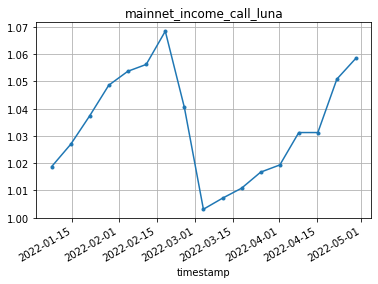

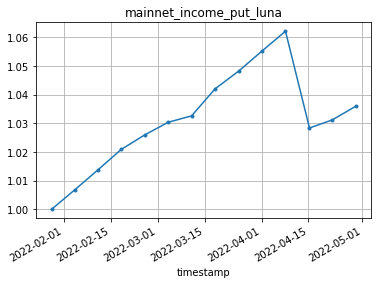

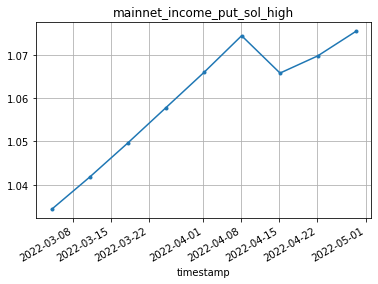

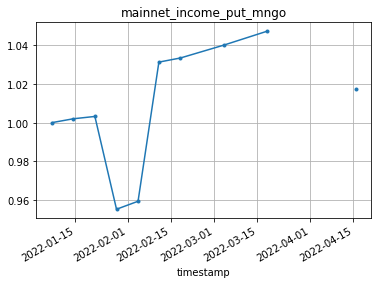

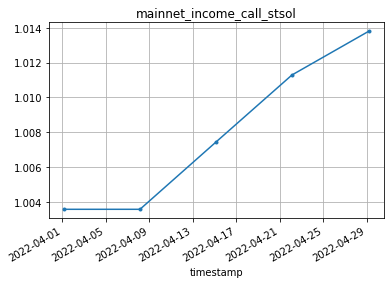

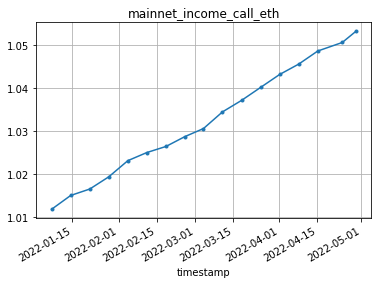

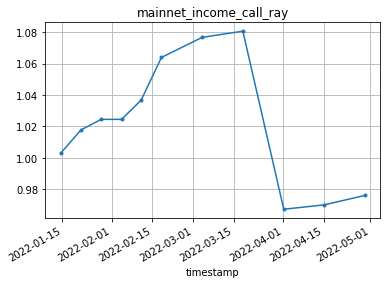

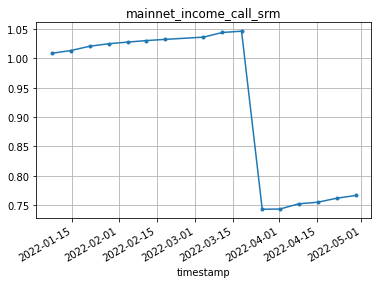

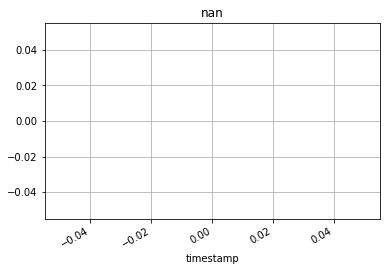

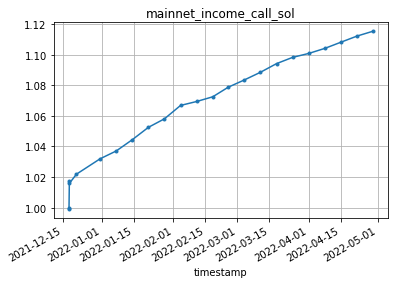

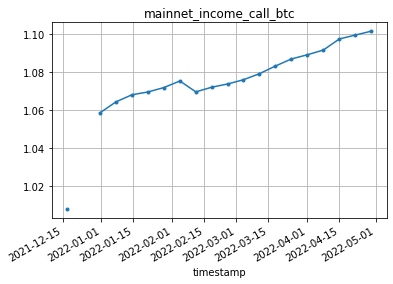

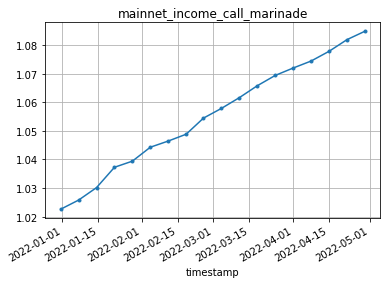

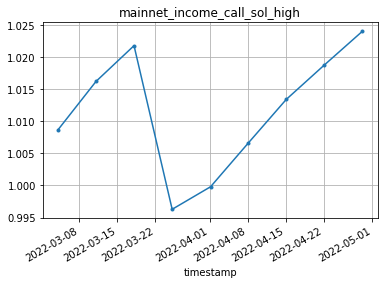

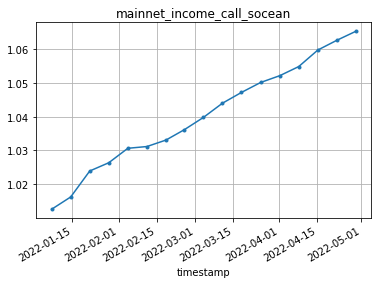

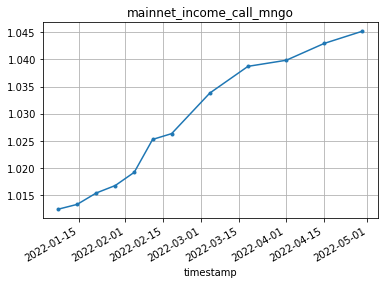

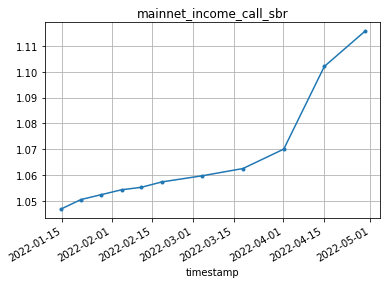

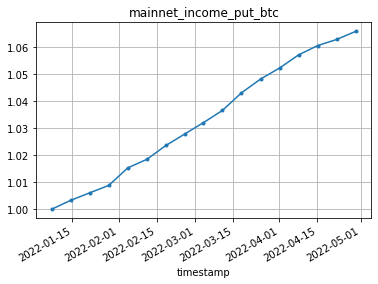

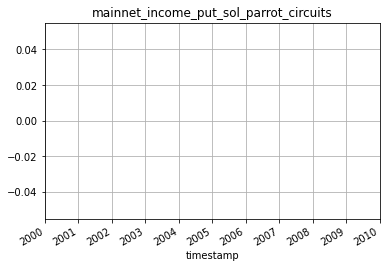

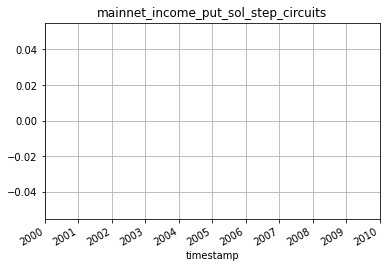

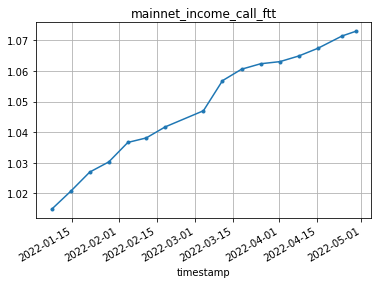

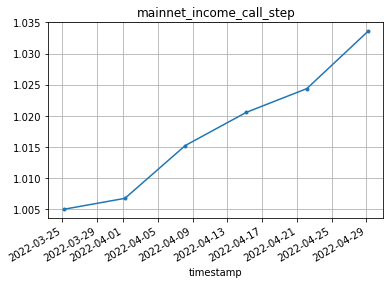

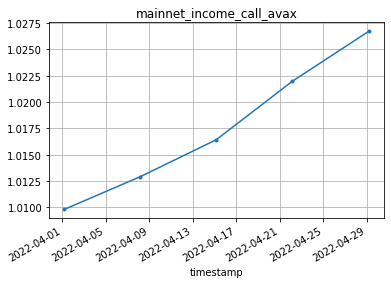

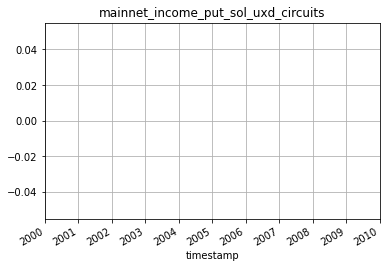

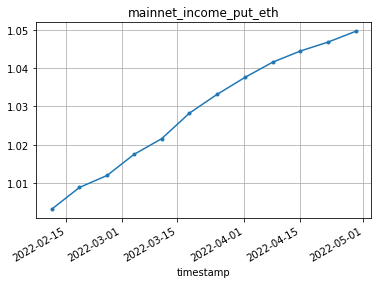

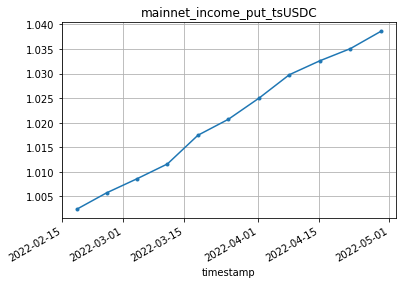

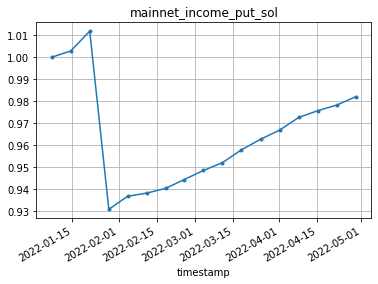

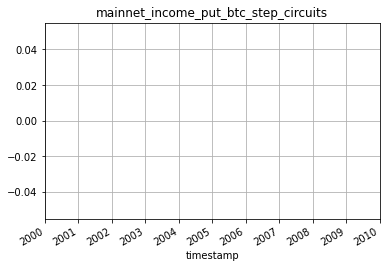

In [341]:
for globalId in end_round.globalId.unique():
    plt.figure()
    temp = end_round.query("globalId == @globalId").copy()
    temp["timestamp"] = pd.to_datetime(temp.timestamp)
    temp.set_index("timestamp").shareTokenPrice.plot(title=globalId, marker='.')
    plt.grid(True)

In [204]:
end_round

,txSignature,amount,instructionAction,instructionOrder,userAddress,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,...,senderAddress_x,senderTokenMint_x,receiverAddress_x,shareTokenPrice,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction
0,1F4bqTsHqYS9nEMsbMpTABGxtPjXK1SJ4vLC7NmxK6r8YN...,4108.701055,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-03-11T02:22:37Z,Wrapped SOL,So11111111111111111111111111111111111111112,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,5GHuBr9njP3KBqXYS7KWRX6z97eYCmqBpn7b5Ae4jeWj,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
1,23Ws8JdskuKa6NwCfL218cjTGHzciNc7m5WFQ5RdimcVTP...,10654.888726,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-03-04T02:43:16Z,NaN,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8,75JcqeoPvbP9L7fEgTgfgF3okorogu8CvVjgupsTe1Hz,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
2,24kgfRXk6hjc25CsAQmt4SGSR7Nt7vNbgs8kxij3csdJTc...,0.000000,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-04-28T02:51:33Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,HXNJ9xq648Ju9uJCZjxybBz4VHajMUCGo9hsF3Sb8Yyz,4peHk7vxSxQoBpfveczGZvYaaKM7SMxSoSP98E16F3bD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
3,26Uqm8u7gQPiWidqyjqSK7uaQv8j6XKjpYpZnDY46cG5x4...,791.963588,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-01-28T09:07:14Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,Ee3qGPkyYnuq6dSaeGqQz69ZYPAyTYHhkcVi9ND19GFs,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
4,26gJjF72t17YCFAK3Zz44SUYyYXkF9SYDgci4nF7T3TX2g...,5013.255659,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-04-08T03:38:19Z,LUNA (Wormhole),F6v4wfAdJB8D8p77bMXZgYt8TDKsYxLYxH5AFhUkYx9W,5oV1Yf8q1oQgPYuHjepjmKFuaG2Wng9dzTqbSWhU5W2X,6bhCxQQWvvM4q8aWSe6UEKcunwGqMErhR2WrmUirtwaZ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,sv8PrQ8SRLbcN6t4nqofbxPzyKyreR4LxKBzsvJVm6r7Yy...,2662.329073,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-01-28T08:49:21Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,GrB6vbG2WP7eEnbwgxUbBGRMeXYq139jo2o9oW8cNK8f,5bHjcoSKns5CVz8MSfp7VnNPotY5eLXr52uBBG5ShNvd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
322,utZkRp7bkcbLWVg2rqQ9DqMGsXCtzvrNbR91wgZ1uqMkgU...,446.177748,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-04-22T03:15:26Z,Lido Staked SOL,7dHbWXmci3dT8UFYWYZweBLXgycu7Y3iL6trKn1Y7ARj,2Ahpeqc1bo7Y4dVknvZUVfZPhHhym7JN6az2XMbUA6QA,AdTq5z1UannEUMhTwNzj5g1vrrwEvUNFNcLfHKbDeD5g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
323,whftpUrFmRj7p6zJRe9yWdaMSXDk4C4Kk9dSCctRjnWDBL...,32217.656908,transfer,0-1,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-04-15T22:35:46Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,CVrRw6VtxSjokm2tKmaS5RCuoc9EFjN4wEoov6f2PST6,J6EaaYnQq1cgvwtUrkWcBb69uMYPdzaebAS2rg3QT8Sn,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound
324,yUaML9jVW8nABTD6PjeWAXykt55SjtXdNdrFycgvq463Sy...,6119.432260,transfer,0-2,DxMJgeSVoe1cWo1NPExiAsmn83N3bADvkT86dSP1k7WE,2022-03-25T02:31:53Z,Wrapped SOL,So11111111111111111111111111111111111111112,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,HiepGSjE1udH3GDTzwHF1bdmNKyuTUiweWu1vsx8okPk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EndRound


/var/folders/t5/lm3g0brx0dsf0ymt1ldc8xdr0000gp/T/ipykernel_24835/54879240.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


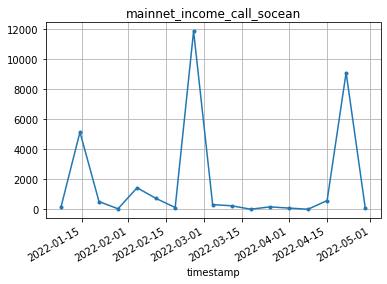

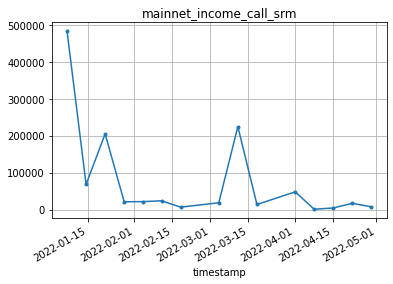

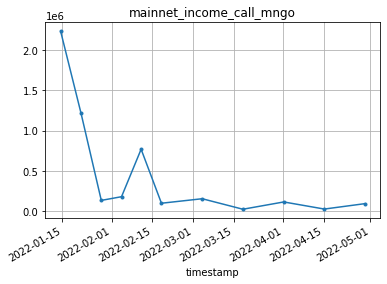

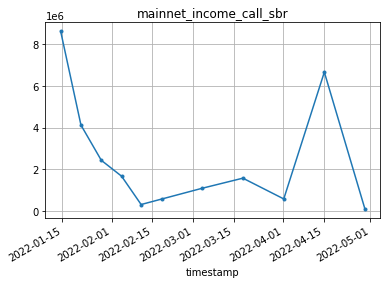

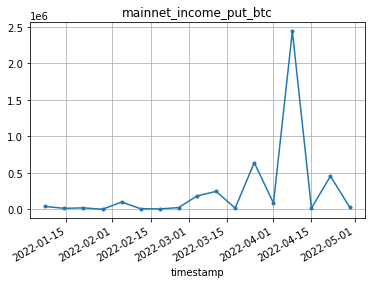

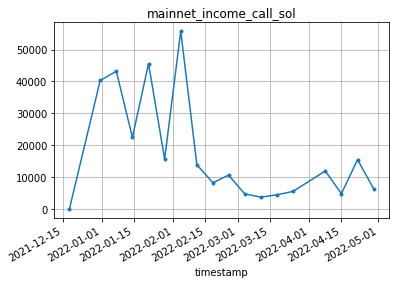

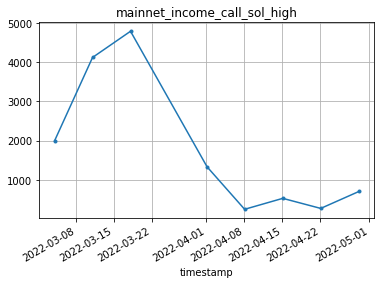

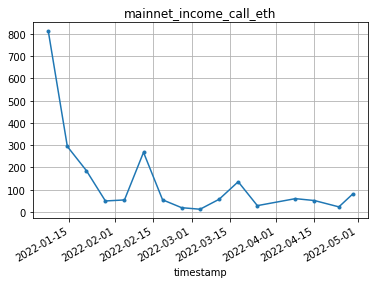

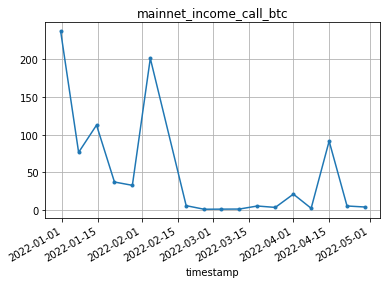

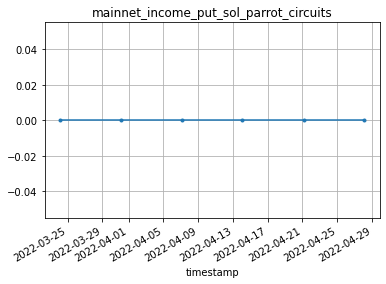

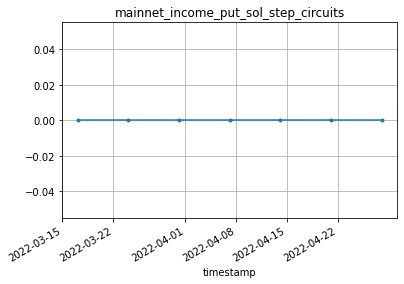

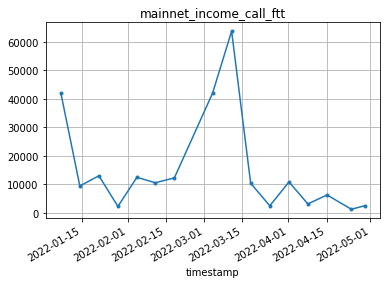

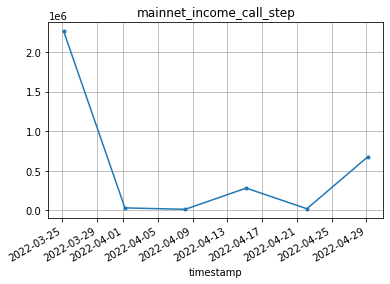

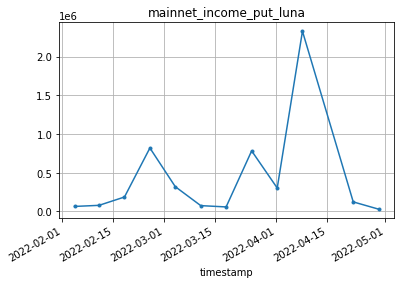

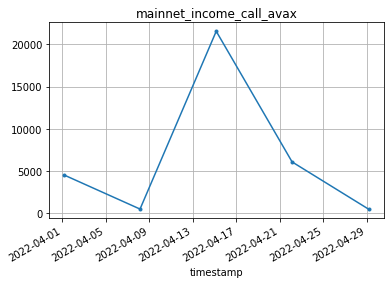

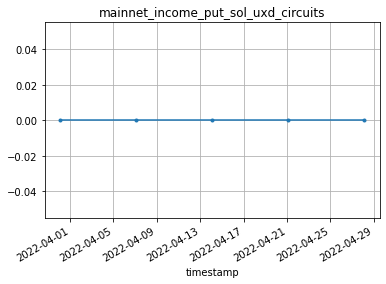

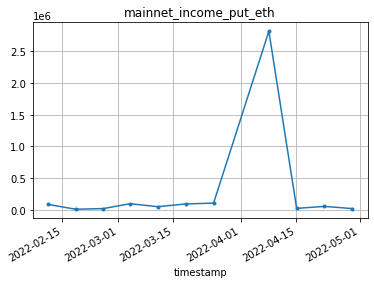

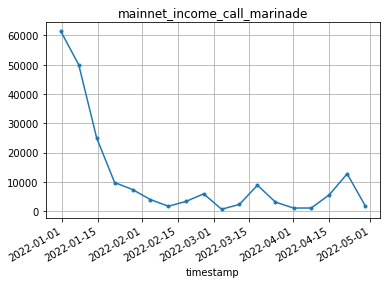

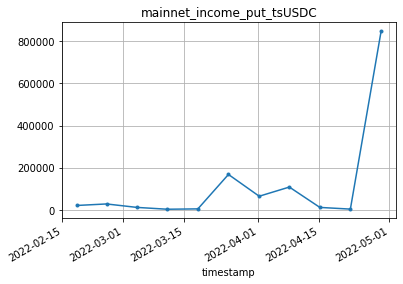

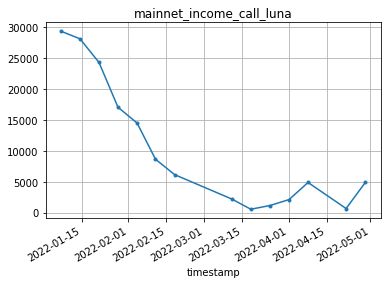

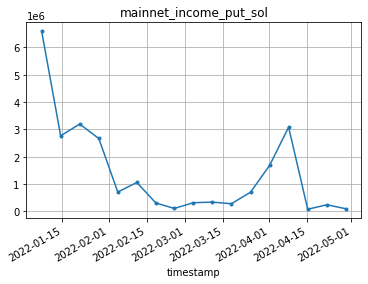

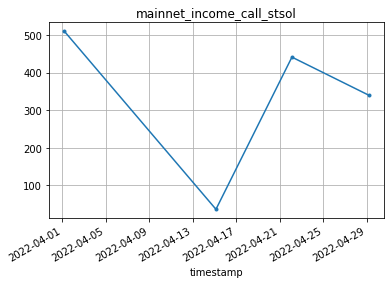

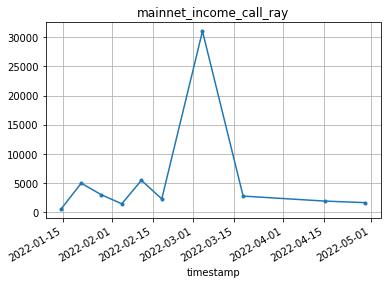

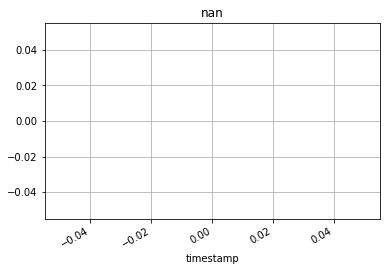

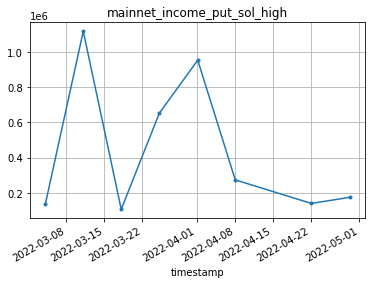

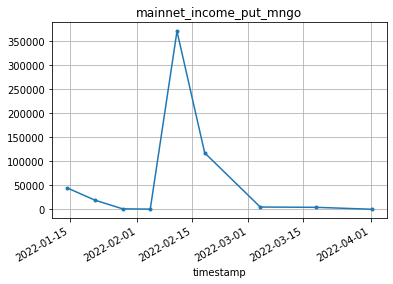

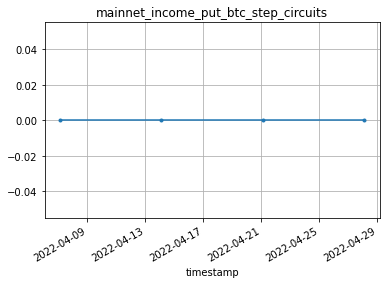

In [189]:
for globalId in end_round.globalId.unique():
    plt.figure()
    temp = end_round.query("globalId == @globalId").copy()
    temp["timestamp"] = pd.to_datetime(temp.timestamp)
    temp.set_index("timestamp").amount.plot(title=globalId, marker='.')
    plt.grid(True)

In [169]:
end_round.loc[end_round.shareTokenPrice.isna()].amount

10     0.0
11     0.0
26     0.0
30     0.0
47     0.0
50     0.0
53     0.0
57     0.0
62     0.0
114    0.0
120    0.0
124    0.0
125    0.0
128    0.0
157    0.0
188    0.0
229    0.0
233    0.0
240    0.0
251    0.0
258    0.0
265    0.0
270    0.0
272    0.0
277    0.0
289    0.0
290    0.0
296    0.0
Name: amount, dtype: float64

In [105]:
ix.loc[ix.instructionType=="EndRound"].txSignature.values

array(['3aYJs5bZjM9AqRBXtJHXXh7trk9f4Dv5UhtXEGshXaV2sDndaj7QsEk1yGfudRoUjVJ651qAA6eHq2cSgGEBXZfw',
       '3RNd4drGrwmQr7oe4dSMiehw4VLMLnhwQQG2BqUYv3o4tbmuEtGtuRMbhbnX1PmbCe2wkqpkgoLWb2HvTcCFy8pY',
       '3gxUdw1kvJcnig6e8422h9Ccg9bArNWMM1Hhrhp3hqex6UHAq1o28XgieBJra1skcUrgKg58tcpXNsK6sBjvyV28',
       'FJD888jPDeep14p2AMVn516jLxXy18n1LX2znq8Xrb7T4eNKvxrqbWVha4CmU8Fr5ECC7GQ5n4qfy88fK1GaHvf',
       '5ivWA9tR5y1SgQ2RF1C7J6E4gG7CTv6kwnbSicP7ojz5TTAkWY2TCD5cBsucuame7GG6D5khSYz3U3UyoVGPwLAT',
       'Pm7M6A5gzcUmSME9xhhh3wsGoe8SG9uwfvtxtJA82yw31DfHGsTcjS1d7zRgik4WkvSzgu42HZ6yFZx5pK7XDFM',
       '3A3Ktcz69vN9aqbSoCTLV6aYjsdS2f2JFGN2UM6r1mpaK31QDnS2PMnCvaWf7WLc4Ntqe8MZVXWAGg52pX5Z7N3o',
       '4AyWmPuiHdnJD46PJHa8VM9aATErWbkJuKmonbY9aEctCrnhjNnFya3CBYmv9DCSmqLr4CBr6ZfbN86g6Ldr7NZR',
       '4Bj21yx9ZYFyBy5HFM98ThJVLftr315bkvuWNAQGBkfw92i3nJm4J6EYMyYSce7o8swQ7LbzMhotLTxQddCYJyWc',
       '4BRUG8SrRGgdZfUyNBEmUXypQmu16bHgh8xTH7oTUYs2wrdgBZKvzPQt7JX9oKh3vD7HKCVkLDhhZ9VECzUExJjK',
       '3QB1

In [4]:
ix.timestamp.max()

'2022-04-03T23:32:20Z'

In [223]:
withdrawals

,txSignature,amount,instructionAction,instructionOrder,userAddress,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,receiverAddress,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction
0,124pSR5mQXtZAQ3vES5QTqkZzyBiyYphVhc3CHkswcibTm...,3.803200e+02,burn,0-1,75JCoqqnK9aHwhGSTrYacwDDPxaySZBHVwxQ9WAdmRic,2022-01-01T07:47:41Z,NaN,DPMCwE9z9jXaDVDti5aKhdgCWGgsvioz6ZvB9eZjH7UE,75JCoqqnK9aHwhGSTrYacwDDPxaySZBHVwxQ9WAdmRic,DMxk7cTKY94j9ks84nBFb1d5H5RisWqcKheuVPzY1mHX,NaN,mainnet_income_call_sbr,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,DPMCwE9z9jXaDVDti5aKhdgCWGgsvioz6ZvB9eZjH7UE,SBR,saber,Withdraw
1,2e2oDbhVmghFLJxt7PAByVnBJSSqHf8TXFkZyPryd51YPd...,6.783181e-01,burn,2-1,CsSL2fTbEUvKTFr5Bp5u8mkPmxNSWA7NeLoJHMYku5i9,2022-01-01T07:59:40Z,NaN,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,CsSL2fTbEUvKTFr5Bp5u8mkPmxNSWA7NeLoJHMYku5i9,5ymHA7Xo45RRc82RYRE9iTuUpNxyvkuv19ktarbrp3eQ,NaN,mainnet_income_call_sol,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,SOL,solana,Withdraw
2,2hUfE3urXF4gXBioRKhDzPbxebVximKvPvykHMwLivq7jp...,3.000000e+03,burn,0-0,7C8f8dxxqQEZyKpHMWaQtfGckrkLgUYmfEH9tjcwB8HT,2022-01-01T06:25:14Z,NaN,EBPM7fvPN8EuA65Uc7DT9eGyDUZ1sqMLM8Rb8y2YxBYU,7C8f8dxxqQEZyKpHMWaQtfGckrkLgUYmfEH9tjcwB8HT,4FMsmFpS2wN6R3BXzoGgZbEg3gSrqe7jH5ocVJyJH17N,NaN,mainnet_income_put_sol,6Nkc8MEiz3WLz1xthYitmSuy3NGwn7782upRHo2iFmXK,EBPM7fvPN8EuA65Uc7DT9eGyDUZ1sqMLM8Rb8y2YxBYU,USDC,usd-coin,Withdraw
3,2jUEu8tq5xBSjfUtsAaUDyJuT7ba5wKeZuuNBdD8sLS9eq...,1.957084e-01,burn,2-1,8763yZEdiDxfigtDrNoncoRWm95ZxmUfjH3FRhx2pNaZ,2022-01-01T14:16:02Z,NaN,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,8763yZEdiDxfigtDrNoncoRWm95ZxmUfjH3FRhx2pNaZ,44dDvkDNaptGNQvNUn76xahRaMf3knKqHYsCv5mMzXj9,NaN,mainnet_income_call_sol,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,SOL,solana,Withdraw
4,2pZX2N78R4ZzwzG7XKLXS65CDKFu5gRBRFE27i9dgtPfkw...,1.957084e-01,burn,2-1,AzdraX1CAboGXtQuLdbuMCCUe6YexSzhCGxQfZ47mP5N,2022-01-01T14:12:43Z,NaN,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,AzdraX1CAboGXtQuLdbuMCCUe6YexSzhCGxQfZ47mP5N,6RjzqzJEBafuNrTvSwexm9KiLaJu1Zd8w5RiH3oE5xRi,NaN,mainnet_income_call_sol,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,SOL,solana,Withdraw
5,2pcVMhvKVWXH6FKJ8Xg1YyAA2khj6VzvxWZYgL8wWrNnWY...,1.957084e-01,burn,2-1,F9FCtdcvLEL8Dn7wL9ThEXz3EvcscX9bQzbUXQiszXzC,2022-01-01T14:14:29Z,NaN,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,F9FCtdcvLEL8Dn7wL9ThEXz3EvcscX9bQzbUXQiszXzC,64xTXckCmiKHnkD9TkuY8Znbqm8oCZzK8gGLtYxiH1Q8,NaN,mainnet_income_call_sol,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,SOL,solana,Withdraw
6,37nVMJcYiXzf78wFz5SxErYSFcR1JdrxEoyXZC4gEZdhCA...,1.259734e+01,burn,3-1,13kgmSo7S4wcjfsTEgsmQDunGq138kTgKhaK1jSVkE5H,2022-01-01T12:14:55Z,NaN,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,13kgmSo7S4wcjfsTEgsmQDunGq138kTgKhaK1jSVkE5H,4Y7xnCiT5UEiawK1eFKzcTmioMDkP9K39Uy7a2dL2z8E,NaN,mainnet_income_call_sol,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,SOL,solana,Withdraw
7,3AvMEehi3zeNz9QZJDEwq5L5fnQQkZz3NG9VSUDQNEnjFF...,2.390000e-03,burn,0-1,GFPXvPpn7oTX56Xf4bNhz52EbfLB9inhGiS141rWdGZ8,2022-01-01T08:11:42Z,NaN,GjnoPUjQiEUYWuKAbMax2cM1Eony8Yutc133wuSun9hS,GFPXvPpn7oTX56Xf4bNhz52EbfLB9inhGiS141rWdGZ8,ESshaD7sX3EWxWpavToRaYZdU6KfzPpTXVc8JU2YunYG,NaN,mainnet_income_call_eth,FThcy5XXvab5u3jbA6NjWKdMNiCSV3oY5AAkvEvpa8wp,GjnoPUjQiEUYWuKAbMax2cM1Eony8Yutc133wuSun9hS,ETH,ethereum,Withdraw
8,3CW2zoTALssgttfNbcbnJpPYqStT8B8eVPGKFdCS6veAXA...,1.541407e+04,burn,1-1,AzdraX1CAboGXtQuLdbuMCCUe6YexSzhCGxQfZ47mP5N,2022-01-01T14:07:36Z,NaN,DPMCwE9z9jXaDVDti5aKhdgCWGgsvioz6ZvB9eZjH7UE,AzdraX1CAboGXtQuLdbuMCCUe6YexSzhCGxQfZ47mP5N,4XZm7N2gJFJTGCrNmZqH5Puytj5c9sBYta8RNGSdTpeN,NaN,mainnet_income_call_sbr,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,DPMCwE9z9jXaDVDti5aKhdgCWGgsvioz6ZvB9eZjH7UE,SBR,saber,Withdraw


In [ ]:
deposits.shape

In [196]:
ix.loc[ix.instructionType=="Deposit"].shape

(29408, 5)

In [197]:
deposits.sort_values("amount")[::-1]

,txSignature,amount,instructionAction,instructionOrder,userAddress,timestamp,currencyName,currencyAddress,senderAddress,senderTokenMint,receiverAddress,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId,userAction
7486,3FvYTiomvJTpAjs5XxGc81egpWzebGXA4sSs7VMvWB6c9G...,4.879066e+06,transfer,1-1,7xTjub4EpTLx7QLHdeJKNQsuVYkqaiGbBd4DJRYjKAYZ,2022-01-13T17:40:28Z,Saber Protocol Token,Saber2gLauYim4Mvftnrasomsv6NvAuncvMEZwcLpD1,7xTjub4EpTLx7QLHdeJKNQsuVYkqaiGbBd4DJRYjKAYZ,3JEfWY4V6sQBQXsbXeWkDVA5pqPisudwhxRbWWd76rt9,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,NaN,NaN,NaN,NaN,NaN,Deposit
11664,3zZ8TKn9gYpFhrqcx8W2HTJikwHSTZLG3GyiqbM12BWPQY...,2.998353e+06,transfer,1-1,CHbwVQQvMvhGxLPBkaL6SZuJ8f895bGHZ5BsLXbaJL3N,2022-02-05T01:47:19Z,NaN,Cvvh8nsKZet59nsDDo3orMa3rZnPWQhpgrMCVcRDRgip,CHbwVQQvMvhGxLPBkaL6SZuJ8f895bGHZ5BsLXbaJL3N,424dm7Lauis6QRBreU9nt8yvwe1FZqUtp6oiEAzMcttQ,AQRGh6PU7LzDHvvoPNS7wVVQaCBeftw9kVDAnvuEjbs8,NaN,NaN,NaN,NaN,NaN,Deposit
19671,5M3H96K3RJghDp5R3SdJsCyeCnRYypTXtL5PvzE6W8wS82...,2.943753e+06,transfer,1-1,GmRC6EhKtBEcKM1bjCBzamWDy3qmP5z2Kc9tYjQuc2Pn,2021-12-30T10:31:36Z,Saber Protocol Token,Saber2gLauYim4Mvftnrasomsv6NvAuncvMEZwcLpD1,GmRC6EhKtBEcKM1bjCBzamWDy3qmP5z2Kc9tYjQuc2Pn,FLEiW8R1qj2XnZ5vuJskFZ1X7umntUJV2DAgFRckcfv5,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,NaN,NaN,NaN,NaN,NaN,Deposit
1691,2GR1JARZMSRP9wEtvVg5D1tbMptBayGuhCt6BuHjevvztx...,2.904146e+06,transfer,0-0,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-07T10:10:46Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,BVrYZ1XpjK85kYKSd2bsQweidBJxHnf8exbpZCNcMdTQ,NaN,NaN,NaN,NaN,NaN,Deposit
25363,JBK4C7XkJKknRMD9NTmiengbiBn9rwNTdFd8MUDvbvsSHa...,2.630611e+06,transfer,1-1,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,2022-03-28T21:44:12Z,USD Coin,EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v,3KNZ9i1dLNNqpBTKEkTgUQs6TNCd3bzuy6HwfoXACaRs,8LrqyZvCsyBVFXDU9YbVAj6ukJ9tSKeXTmXNHWfZkGRF,8ENPcthqhuWVaTG3eE28zJHxm4BWzyiyCFgqZL44szTY,NaN,NaN,NaN,NaN,NaN,Deposit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15554,4eVtsrbxsB5yKwANXpWQU5kH5Qc3HAD37ak8L9uzk5GEeU...,1.000000e-09,transfer,0-0-0,GgF8AhcdiJ4hhyFaMoJ3XpQo9q7NgFnNaMQ6x6Xj3Lvt,2021-12-27T02:05:05Z,Marinade staked SOL (mSOL),mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So,6qfyGvoUqGB6AQ7xLc4pVwFNdgJSbAMkTtKkBXhLRiV1,5Vfn9EmBYkxDFASQKLEZqDuDCT2G2tbmNrizisa4m4uL,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,NaN,NaN,NaN,NaN,NaN,Deposit
12164,45X8ZKAUZUPZBVorVhavjAgncR2KXynevXNB9sRkAwbSQH...,1.000000e-09,transfer,1-1,J1sFjvcmhAxiYS5oerp167VDCu1u76csG5bXkkgijVJn,2022-01-24T23:48:03Z,Marinade staked SOL (mSOL),mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So,J1sFjvcmhAxiYS5oerp167VDCu1u76csG5bXkkgijVJn,EqXN26d6mKUKPXrziWxaHxF7wsDzt95vWPnFkFMe7Nok,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,NaN,NaN,NaN,NaN,NaN,Deposit
16534,4pSgwJkyp6PuitQMC5UiKoJiV1bmUUk9E7VzE73Ds9XMqb...,1.000000e-09,transfer,1-1,GFZpgo47bsmPzLentNshwHnapbryMiu1hfisng7DBbDm,2022-03-30T09:39:59Z,Marinade staked SOL (mSOL),mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So,GFZpgo47bsmPzLentNshwHnapbryMiu1hfisng7DBbDm,5BMHymXSNFgyoGYzxx6b9yGTTq4zRwXzCkrwu2SUFs2n,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,NaN,NaN,NaN,NaN,NaN,Deposit
2386,2PXZks2t4YUZWQuDc6MNo1nLre5SgMWhumRvGx4jqemQSS...,1.000000e-09,transfer,0-0,5cvX5RGXCbX12Rso1UCTFFDdzgN9W7jMTHCDzKAthmuo,2022-01-26T21:29:48Z,Marinade staked SOL (mSOL),mSoLzYCxHdYgdzU16g5QSh3i5K3z3KZK7ytfqcJm7So,5cvX5RGXCbX12Rso1UCTFFDdzgN9W7jMTHCDzKAthmuo,EFHB1NyzjTQW7hmAorGzHBoUqdVZDsGQ4jDVyPMXTvjn,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,NaN,NaN,NaN,NaN,NaN,Deposit


In [163]:
pd.options.display.width = 0

In [177]:
deposits.loc[
    deposits.vaultAuthority=="Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G"].sort_values("amount")[["timestamp", "amount", "txSignature"]]

,timestamp,amount,txSignature
7978,2022-02-25T19:56:08Z,1.000000e-09,mQPf6mdLdSpCtnmvPkKarwhMykNNp5FEzKg6yzvJbo12yG...
5862,2022-02-12T02:52:57Z,1.000000e-09,5VtrMPM6nGsWSzeWrFQ4dQFnHyixUMmK4GXF5wzyRsYp2L...
479,2022-02-03T21:05:08Z,1.000000e-09,2H4hQFTSkvWJUTr3t5f9i8hFDG1XW7Rak31WoiDLqf733t...
4532,2022-03-18T14:21:43Z,1.000000e-09,4h55mB7Hwosedtx3kttVfbLmAGdKoHkKRoSY7fhBoufYVU...
5087,2022-01-07T15:34:27Z,1.000000e-09,52jsKGk4ryoqbQCiNnZg1TcDJ81RHxq5PrptiunnjW3TJb...
...,...,...,...
2415,2022-01-12T08:06:22Z,3.638800e+03,3Rkt6Z9QHzxxrP6FhVoLA4jkcKCXJPjASDsjeUHmbbBsUd...
4309,2022-03-30T16:18:44Z,8.230664e+03,4a2KegHZpt2Mfp45FjcbFUVV1HsMHSHzyN6kfML9mJ8qrN...
4799,2022-02-01T16:45:17Z,8.586272e+03,4rbL6s8PcsHaPBBM5Sf1mgGBkQHUvVo8zxa5VhP92oU2oN...
2362,2022-02-17T09:13:40Z,1.168541e+04,3PezBkLDECULRfmgLNz92qZewjzC6oAbr7xAbstGTuV1CN...


In [176]:
deposits.loc[
    deposits.vaultAuthority=="Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G"].sort_values("amount")[["timestamp", "amount", "txSignature"]][::-1].iloc[3]["txSignature"]


'4a2KegHZpt2Mfp45FjcbFUVV1HsMHSHzyN6kfML9mJ8qrN4iQKGUWPXBetXMrGKDRtu8JuhZPC4ttBZqaiAtL3dD'

In [ ]:
depsots

In [111]:
deposits.columns

Index(['txSignature', 'amount', 'instructionAction', 'instructionOrder',
       'userAddress', 'timestamp', 'currencyName', 'currencyAddress',
       'senderAddress', 'senderTokenMint', 'receiverAddress', 'globalId',
       'vaultAuthority', 'shareTokenMint', 'depositTokenSymbol',
       'depositTokenCoingeckoId', 'userAction'],
      dtype='object')

In [ ]:
deposits

In [28]:
# Have Price
# Have VoltTokenShare

In [27]:
deposits.columns

Index(['txSignature', 'amount', 'instructionAction', 'instructionOrder',
       'userAddress', 'timestamp', 'currencyName', 'currencyAddress',
       'senderAddress', 'senderTokenMint', 'receiverAddress', 'globalId',
       'vaultAuthority', 'shareTokenMint', 'depositTokenSymbol',
       'depositTokenCoingeckoId'],
      dtype='object')

In [16]:
deposits.shape

(115, 16)

In [26]:
deposits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   txSignature              115 non-null    object 
 1   amount                   115 non-null    float64
 2   instructionAction        115 non-null    object 
 3   instructionOrder         115 non-null    object 
 4   userAddress              115 non-null    object 
 5   timestamp                115 non-null    object 
 6   currencyName             115 non-null    object 
 7   currencyAddress          115 non-null    object 
 8   senderAddress            115 non-null    object 
 9   senderTokenMint          115 non-null    object 
 10  receiverAddress          115 non-null    object 
 11  globalId                 115 non-null    object 
 12  vaultAuthority           115 non-null    object 
 13  shareTokenMint           115 non-null    object 
 14  depositTokenSymbol       1

In [17]:
deposits.columns

Index(['txSignature', 'amount', 'instructionAction', 'instructionOrder',
       'userAddress', 'timestamp', 'currencyName', 'currencyAddress',
       'senderAddress', 'senderTokenMint', 'receiverAddress', 'globalId',
       'vaultAuthority', 'shareTokenMint', 'depositTokenSymbol',
       'depositTokenCoingeckoId'],
      dtype='object')

In [147]:
deposits.iloc[0]

txSignature                122tbxak1CeaRQSMZD2izGb9tXa7rSaRpyD2s3iSv4bKp3...
amount                                                              1.062448
instructionAction                                                       burn
instructionOrder                                                         1-1
userAddress                     GbYTQgbXndUJoczx23Hy3hobAReguEuddijnsRTkn8pJ
timestamp                                               2022-01-09T10:12:13Z
currencyName                                                             NaN
currencyAddress                 6UA3yn28XecAHLTwoCtjfzy3WcyQj1x13bxnH8urUiKt
senderAddress                   GbYTQgbXndUJoczx23Hy3hobAReguEuddijnsRTkn8pJ
senderTokenMint                 2ALneL69HRuthso7f4inq75g8AYBTbKHKgFB2oBgE6mh
receiverAddress                                                          NaN
globalId                                                                 NaN
vaultAuthority                                                           NaN

In [19]:
deposits.loc[deposits.depositTokenCoingeckoId.isna()].currencyAddress

Series([], Name: currencyAddress, dtype: object)

In [20]:
deposits.shape

(115, 16)

In [21]:
deposits.loc[deposits.txSignature=="24y4KRma4BUarjw4y8Rv9Dt1kZdVVSP5kVnkbu4Ra5KMs7G9Df2Vb9C1b3M8f6yCuNuhsEW9s1WR8WrSKuN5bVBX"].iloc[0]

txSignature                24y4KRma4BUarjw4y8Rv9Dt1kZdVVSP5kVnkbu4Ra5KMs7...
amount                                                                 551.0
instructionAction                                                   transfer
instructionOrder                                                         3-1
userAddress                     9T19SkKUpSNbt2cMcCQVz7NZEfmXW3gdMDkH9db1yidw
timestamp                                               2022-03-17T18:39:38Z
currencyName                                                     Wrapped SOL
currencyAddress                  So11111111111111111111111111111111111111112
senderAddress                   9T19SkKUpSNbt2cMcCQVz7NZEfmXW3gdMDkH9db1yidw
senderTokenMint                 D9QnLjbjTEBCqFZUrovoFkNW3B8gLmsJkT6PDt4HUv1H
receiverAddress                  wJAoeEG2sfQ1xgXUNVVkJ5mCTCw4SLc6oJafDwf6jTf
globalId                                        mainnet_income_call_sol_high
vaultAuthority                   wJAoeEG2sfQ1xgXUNVVkJ5mCTCw4SLc6oJafDwf6jTf

In [22]:
deposits.loc[deposits.txSignature=="1kx6PYTANDwsAZGZ5xoRNe51uRK68k6roF6KYDauHQMmemH4JunDBCA47oHT2J1QUbh5YJHFdoZtQECqUVLVbZp"].iloc[0]

txSignature                1kx6PYTANDwsAZGZ5xoRNe51uRK68k6roF6KYDauHQMmem...
amount                                                               0.99859
instructionAction                                                   transfer
instructionOrder                                                         1-1
userAddress                     79jbRVMQu5rQkEcAPbzZNqnwKEASHyEyWgUn9q76yUKT
timestamp                                               2022-03-17T19:33:26Z
currencyName                                       Wrapped Ethereum (Sollet)
currencyAddress                 2FPyTwcZLUg1MDrwsyoP4D6s1tM7hAkHYRjkNb5w6Pxk
senderAddress                   79jbRVMQu5rQkEcAPbzZNqnwKEASHyEyWgUn9q76yUKT
senderTokenMint                 3e81Tr2AGVLwPLLsUwiBSaYdGDwSxCMXmhF5ZWUuQAsn
receiverAddress                 FThcy5XXvab5u3jbA6NjWKdMNiCSV3oY5AAkvEvpa8wp
globalId                                             mainnet_income_call_eth
vaultAuthority                  FThcy5XXvab5u3jbA6NjWKdMNiCSV3oY5AAkvEvpa8wp

In [149]:
zz = pd.DataFrame(
                dict(
                    json.loads(
                        requests.get(
                            "https://friktion-labs.github.io/mainnet-tvl-snapshots/friktionSnapshot.json"
                        ).content
                    )
                )["allMainnetVolts"]
            )

In [150]:
zz

,globalId,vaultAuthority,shareTokenMint,depositTokenSymbol,depositTokenCoingeckoId
0,mainnet_income_call_btc,DA1M8mw7GnPNKU9ReANtHPQyuVzKZtsuuSbCyc2uX2du,3BjcHXvyzMsjmeqE2qFLx45K4XFx3JPiyRnjJiF5MAHt,BTC,bitcoin
1,mainnet_income_call_sol,Hxtb6APfNtf9m8jJjh7uYp8fCTGr9aeHxBSfiPqCrV6G,4Hnh1UCC6HLzx9NaGKnTVHR2bANcRrhydumdHCnrT3i2,SOL,solana
2,mainnet_income_call_sol_high,wJAoeEG2sfQ1xgXUNVVkJ5mCTCw4SLc6oJafDwf6jTf,DNa849drqW19uBV5X9ohpJ5brRGzq856gk3HDRqveFrA,SOL,solana
3,mainnet_income_call_marinade,6asST5hurmxJ8uFvh7ZRWkrMfSEzjEAJ4DNR1is3G6eH,6UA3yn28XecAHLTwoCtjfzy3WcyQj1x13bxnH8urUiKt,mSOL,msol
4,mainnet_income_call_eth,FThcy5XXvab5u3jbA6NjWKdMNiCSV3oY5AAkvEvpa8wp,GjnoPUjQiEUYWuKAbMax2cM1Eony8Yutc133wuSun9hS,ETH,ethereum
5,mainnet_income_call_ftt,7KqHFuUksvNhrWgoacKkqyp2RwfBNdypCYgK9nxD1d6K,7wDh4VCTPwx41kvbLE6fkFgMEjnqw7NpGJvQtNabCm2B,FTT,ftx-token
6,mainnet_income_call_srm,2P427N5sYcEXvZAZwqNzjXEHsBMESQoLyjNquTSmGPMb,5SLqZSywodLS8ih6U2AAioZrxpgR149hR8SApmCB7r5X,SRM,serum
7,mainnet_income_call_mngo,B3yakZxwomkmnCxRr8ZmQtiWgtxtVBuCREDFDdAvcCVQ,4sTuzTYfcE2NF7zy6Sy8XhVcNLa6JQSLrx3roy97n4sD,MNGO,mango-markets
8,mainnet_income_call_socean,A5MpyajTy6hdsg3S2em5ukcgY1ZBhxTxEKv8BgHajv1A,5VmdHqvRMbXivuC34w4Hux9zb1y9moiBEQmXDrTR1kV,scnSOL,socean-staked-sol
9,mainnet_income_call_sbr,BH7Jg3f97FyeGxsPR7FFskvfqGiaLeUnJ9Ksda53Jj8h,DPMCwE9z9jXaDVDti5aKhdgCWGgsvioz6ZvB9eZjH7UE,SBR,saber
